# __Reviewer feedback analysis 1__

On:
- Cause of growth in China/India publication volume
- Determination of false negative rate using MeSH term "Plants"

## ___Setup___

In [1]:
# for counting the 17 journals
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.optimize import curve_fit

# for medline parser
import sys
import pickle
dir_pubmed_parser = Path.home() / "github/pubmed_parser/"
sys.path.insert(0, str(dir_pubmed_parser))
from pubmed_parser.medline_parser import parse_medline_xml
from itertools import chain
from tqdm import tqdm

proj_dir = Path.home() / "projects/plant_sci_hist"

## ___Number of papers from the top 17 plant science journals___

Reviewer 1 indicated that:

"Similarly, it is unclear to which extent the growth reported for China and India is truly exceptional growth of plant research in these countries, or increased publishing in English, or efforts of NCBI to include literature written in languages other than English. While such a distinction could be obtained by analyzing plant-related publications contained in OpenAlex, a few extra words would seem to suffice."

Finding:
- The top 17 journals have very similar trend as the overall result from the entire corpus. Since the top 17 journals are all in English, it does not seem that increased publishing in English is the reason.
- In later section, we found that Plant Science Corpus has 97% of records from journals in English. Thus, the impact of non-English journal is expected to be minimal and the pattern we see is unlikely to be influenced by efforts of NCBI to include non-English literature.
- Therefore, there appears to be exceptional growth in plant reseach publications in higher impact journals from India and China which cannot be explained by the above two factors.

In [2]:
dir92 = proj_dir / "9_wrap_up/9_2_ci_j17"
dir92.mkdir(parents=True, exist_ok=True)

# Topic dataframe
dir42       = proj_dir / "4_topic_model/4_2_outlier_assign"
corpus_file = dir42 / "table7_5_corpus_with_topic_assignment_nodup.tsv.gz"
tdf         = pd.read_csv(corpus_file, sep='\t', compression='gzip', 
                          index_col=[0])

In [3]:
# Country information
dir75   = proj_dir / "7_countries/7_5_country_over_time"
ci_file = dir75 / 'ci_pmid_topic.tsv'
ci      = pd.read_csv(ci_file, sep='\t')

ci.head(2)

,PMID,A3,Confidence,Date,Topic,Year
0,400957,CAN,3,1978-01-01,50,1978
1,1279107,FRA,3,1992-11-01,12,1992


In [4]:
# get subset of columns in tdf
pmid_j = tdf[['PMID', 'Journal']]

# join country data with tdf
ci_j = pd.merge(ci, pmid_j, on='PMID')

tdf.shape, ci.shape, ci_j.shape

((421307, 12), (330328, 6), (330328, 7))

In [5]:
ci_j.head(2)

,PMID,A3,Confidence,Date,Topic,Year,Journal
0,400957,CAN,3,1978-01-01,50,1978,"Comparative biochemistry and physiology. B, Co..."
1,1279107,FRA,3,1992-11-01,12,1992,The Journal of general virology


In [6]:
# Filter ci_j based on the top 17 journals
psj17 = ['Plant physiology', 'Frontiers in plant science', 'Planta',
          'The Plant journal : for cell and molecular biology', 
          'Journal of experimental botany', 'Plant molecular biology',
          'The New phytologist', 'The Plant cell', 'Phytochemistry',
          'Plant &amp; cell physiology', 'American journal of botany',
          'Annals of botany', 'BMC plant biology', 'Tree physiology',
          'Molecular plant-microbe interactions : MPMI',
          '"Plant biology (Stuttgart, Germany)"', 
          'Plant biotechnology journal']

ci_j17 = ci_j[ci_j['Journal'].isin(psj17)]

ci_j17.shape, ci_j17.shape[0] / ci_j.shape[0]

((72777, 7), 0.22031738151170957)

/tmp/ipykernel_94728/4049704135.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  num_yr_ci_j17 = ci_j17['Year'].value_counts().sort_index()[:-1]


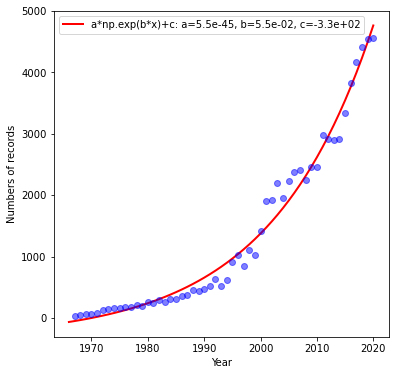

In [7]:
# count number of articles per year, rid of data from 2021
num_yr_ci_j17 = ci_j17['Year'].value_counts().sort_index()[:-1]

# following codes are from 4.4
X = num_yr_ci_j17.index
Y = num_yr_ci_j17.values

def exp_func(X, a, b, c):
  return a*np.exp(b*X) + c

# Curve fit
popt_exp, _ = curve_fit(exp_func, X, Y, p0=(1, 1e-6, 1), maxfev=10000)
popt_exp

# Plotting
fig_fit_yr_docnum = dir92 / "fig9_2_year_docnum_exponential_fit_j17.pdf"

#y_pred = [exp_func(x, *popt_exp) for x in X]
plt.figure(figsize=(6, 6))
plt.plot(X, exp_func(X, *popt_exp),'r',linewidth=2, 
        label='a*np.exp(b*x)+c: a=%.1e, b=%.1e, c=%.1e' % tuple(popt_exp))
plt.plot(X[1:], Y[1:], 'bo', alpha=0.5)
#plt.plot(x[1:], y_pred[1:], '-b')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Numbers of records")
plt.savefig(fig_fit_yr_docnum, format='pdf')
plt.show()

In [8]:
# Single out USA, GRB, IND, and CHN for counts
ci_j17_usa = ci_j17[ci_j17['A3'] == 'USA']
ci_j17_grb = ci_j17[ci_j17['A3'] == 'GBR']
ci_j17_ind = ci_j17[ci_j17['A3'] == 'IND']
ci_j17_chn = ci_j17[ci_j17['A3'] == 'CHN']

# count number of articles per year, rid of data from 2021
num_yr_ci_j17_usa = ci_j17_usa['Year'].value_counts().sort_index().iloc[:-1]
num_yr_ci_j17_grb = ci_j17_grb['Year'].value_counts().sort_index().iloc[:-1]
num_yr_ci_j17_ind = ci_j17_ind['Year'].value_counts().sort_index().iloc[:-1]
num_yr_ci_j17_chn = ci_j17_chn['Year'].value_counts().sort_index().iloc[:-1]

# Normalized counts based on total from each country
norm_usa = num_yr_ci_j17_usa / sum(num_yr_ci_j17_usa)*100
norm_grb = num_yr_ci_j17_grb / sum(num_yr_ci_j17_grb)*100
norm_ind = num_yr_ci_j17_ind / sum(num_yr_ci_j17_ind)*100
norm_chn = num_yr_ci_j17_chn / sum(num_yr_ci_j17_chn)*100

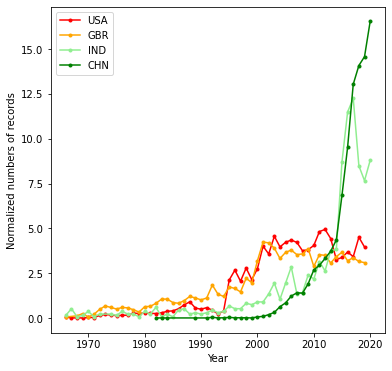

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(norm_usa, ".-", c="red")
plt.plot(norm_grb, ".-", c="orange")
plt.plot(norm_ind, ".-", c="lightgreen")
plt.plot(norm_chn, ".-", c="green")
plt.legend(['USA', 'GBR', 'IND', 'CHN'])
plt.xlabel("Year")
plt.ylabel("Normalized numbers of records")
plt.savefig(dir92 / "fig9_2_year_docnum_normalized_4countries.pdf", 
            format='pdf')
plt.show()

## ___FP/FN evaluation based on MeSH___

Reviewer 1 indicated that:

  "Independent of above paragraph, it would be good to see an evaluation of false positive/false negatives in the creation of the corpus. Comparing against a corpus formed by NCBI's MeSH term D010944 (Plants) would seem reasonable as they are an authority and follows good practices. The authors could, for instance, obtain MeSH by running pubmed_parser on the files that they already downloaded, and obtain the children terms of D010944 via the definition of MeSH terms downloadable on NCBI/MeSH's ftp server."


Issues with MeSH terms:
- Not all plant science records will have the Plants MesH term.
- Some terms like Viridiplantae is only introduced since 2011, so incomplete. Should not be used.

### Get MeSH terms

In [10]:
# parse the mesh terms with medline parser, see what's in the function
help(parse_medline_xml)

Help on function parse_medline_xml in module pubmed_parser.medline_parser:

parse_medline_xml(path, year_info_only=True, nlm_category=False, author_list=False, reference_list=False, parse_downto_mesh_subterms=False)
    Parse XML file from Medline XML format available at
    https://ftp.ncbi.nlm.nih.gov/pubmed/
    
    
    Parameters
    ----------
    path: str
        The path
    year_info_only: bool
        if True, this tool will only attempt to extract year information from PubDate.
        if False, an attempt will be made to harvest all available PubDate information.
        If only year and month information is available, this will yield a date of
        the form 'YYYY-MM'. If year, month and day information is available,
        a date of the form 'YYYY-MM-DD' will be returned.
        NOTE: the resolution of PubDate information in the Medline(R) database varies
        between articles.
        default: True
    nlm_category: bool
        if True, this will parse structur

In [11]:
dir93 = proj_dir / "9_wrap_up/9_3_mesh"
dir93.mkdir(parents=True, exist_ok=True)

# Specifiy pubmed xml location
dir_xml = proj_dir / "1_obtaining_corpus/pubmed"
subdirs = ["0000", "0200", "0400", "0600", "0800", "1000"]

In [12]:
xml_article_fields = dir93 / "xml_article_fileds.pkl"

if xml_article_fields.is_file():
  print("Read article fields from pickle")
  with open(xml_article_fields, "rb") as f:
    article_fileds = pickle.load(f)
else:
  # {pmid: {mesh xx, country: xx, lang: xx}}
  article_fileds = {} 

  # Iterate through xmls
  for subdir in subdirs:
    print(subdir)
    xml_list = list((dir_xml / subdir).glob("*.xml.gz"))
    for xml_file in xml_list:
      print("", xml_file)
      # Each item in the iterator is a dictionary that have the following keys:
      # dict_keys(['title', 'issue', 'pages', 'abstract', 'journal', 'authors', 
      #            'pubdate', 'pmid', 'mesh_terms', 'publication_types', 
      #            'chemical_list', 'keywords', 'doi', 'references', 'delete', 
      #            'languages', 'vernacular_title', 'affiliations', 'pmc', 
      #            'other_id', 'medline_ta', 'nlm_unique_id', 'issn_linking', 
      #            'country', 'grant_ids'])
      article_iter = parse_medline_xml(str(xml_file))
      
      for article in tqdm(article_iter):
        pmid    = article['pmid']
        mesh    = article['mesh_terms']
        country = article['country']
        lang    = article['languages']
        article_fileds[pmid] = {'mesh': mesh, 'country': country, 'lang': lang}

  with open(dir93 / "xml_article_fileds.pkl", "wb") as f:
    pickle.dump(article_fileds, f)

Read article fields from pickle


In [13]:
# Examine an example 
for pmid in article_fileds:
  print(pmid, article_fileds[pmid]['mesh'].split("; "))
  break

1 ['D000445:Aldehyde Oxidoreductases', 'D000818:Animals', 'D001826:Body Fluids', 'D002245:Carbon Dioxide', 'D005561:Formates', 'D000882:Haplorhini', 'D006801:Humans', 'D006863:Hydrogen-Ion Concentration', 'D007700:Kinetics', 'D000432:Methanol', 'D008722:Methods', 'D011549:Pseudomonas']


### Get D010944 records

In [14]:
# Get all articles with MESH term ID D010944 for Plants
pmid_plants = {}
for pmid, fields in tqdm(article_fileds.items()):
  if "D010944" in fields['mesh']:
    # turn pmid into int to be comparable with pmid in the corpus
    pmid_plants[int(pmid)] = 1

len(pmid_plants)

100%|██████████| 31920091/31920091 [00:13<00:00, 2357823.62it/s]


78066

In [15]:
with open(dir93 / "pmid_plants_D010944.pkl", "wb") as f:
  pickle.dump(pmid_plants, f)

### Determine overlap between D010944 records and candidate plant records

In [16]:
# candidate file
dir25      = proj_dir / "2_text_classify/2_5_predict_pubmed"
cand_file = dir25 / "pubmed_qual_1384718_w2v_pred_prob.tsv.gz"

# Turn candidate file into a dataframe
cand_df = pd.read_csv(cand_file, sep='\t', compression='gzip')

/tmp/ipykernel_94728/3441403485.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  cand_df = pd.read_csv(cand_file, sep='\t', compression='gzip')


In [17]:
cand_df.head(2)

,Unnamed: 0,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,reg_article,y_prob,y_pred
0,0,36,1975-11-01,The British journal of nutrition,The effects of processing of barley-based supp...,1. In one experiment the effect on rumen pH of...,barley,The effects of processing of barley-based supp...,1,0.162140,0
1,1,52,1975-12-02,Biochemistry,Evidence of the involvement of a 50S ribosomal...,The functional role of the Bacillus stearother...,rose,Evidence of the involvement of a 50S ribosomal...,1,0.286834,0


In [18]:
# Because the records were concatenated together, there are some rows that are
# just column headers. Rid of them. Note the PMID is in mixed, covert all to int

cand_df2 = cand_df[cand_df['PMID'].apply(lambda x: str(x).isdigit())]
pmids    = cand_df2['PMID'].values
cand_df2['PMID'] = pmids

cand_file_corrected = dir25 / "pubmed_qual_1384718_w2v_pred_prob_CORRECTED.tsv.gz"
cand_df2.to_csv(cand_file_corrected, sep='\t', compression='gzip', index=False)

pmid_cand = {pmid:1 for pmid in cand_df2['PMID'].tolist()}

len(pmid_cand)

/tmp/ipykernel_94728/4229837505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cand_df2['PMID'] = pmids


1383681

In [19]:
count_in_cand = 0
in_cand     = []
not_in_cand = []
for pmid in tqdm(pmid_plants):
  if pmid in pmid_cand:
    in_cand.append(pmid)
  else:
    not_in_cand.append(pmid)

print(len(in_cand), len(not_in_cand), len(pmid_plants), 
      len(in_cand)/len(pmid_plants))

100%|██████████| 78066/78066 [00:00<00:00, 1555565.49it/s]

35860 42206 78066 0.45935490482412317


In [20]:
# Get the records for D010944 in the candidate file
cand_df_with_mesh = cand_df[cand_df['PMID'].isin(in_cand)]
cand_df_with_mesh.shape

(35860, 11)

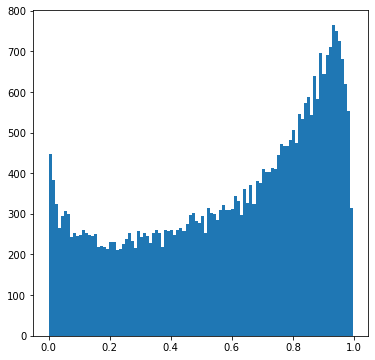

In [21]:
# plot the y_prob
fig_y_prob = dir93 / "fig9_3_y_prob_D010944.pdf"
plt.figure(figsize=(6, 6))
plt.hist(cand_df_with_mesh['y_prob'], bins=100)
plt.show()

### Determine overlap between D010944 records in candidate plant records with y_pred=1

Examine the list of articles not in the plant science corpus:
- 35,860 records with D010944 that are in the candidate corpus
 - 22,861 with y_pred=1 (63.8%),
 - 12,999 with y_pred=0,


In [22]:
cand_df_with_mesh.shape

(35860, 11)

In [23]:
cand_df_with_mesh['y_pred'].value_counts()

1    22861
0    12999
Name: y_pred, dtype: int64

In [24]:
22861/35860

0.6375069715560513

In [25]:
# Get the records that are not_in_corpus but in_cand
not_in_corpus = cand_df_with_mesh[cand_df_with_mesh["y_pred"] == 0]
not_in_corpus.to_csv(dir93 / "not_in_corpus_but_in_cand.csv", 
                                 index=False)
# spot check
not_in_corpus.shape

(12999, 11)

### Determine overlap between D010944 and the 17 plant science journals

In [26]:
# total number of j17 records in the corpus
tdf_j17 = tdf[tdf['Journal'].isin(psj17)]
tdf_j17.shape

(93263, 12)

In [27]:
# total number of j17 records in the corpus with the mesh term D010944
tdf_j17_plants = tdf_j17[tdf_j17['PMID'].isin(pmid_plants)]
tdf_j17_plants.shape

(3534, 12)

In [28]:
# number of j17 records with the mesh term but not in the corpus
not_in_corpus_j17 = not_in_corpus[not_in_corpus['Journal'].isin(psj17)]
not_in_corpus_j17.shape

(470, 11)

In [30]:
470/(470+3534), 470+3534

(0.11738261738261738, 4004)

### Check the number of articles in English

In [ ]:
# Check the number of articles in English in the plant science corpus
count_en = 0

pmid_corpus = cand_df2[cand_df2['y_pred'] == 1]['PMID'].values

for pmid in pmid_corpus:
  if article_fileds[pmid]['lang'] == 'eng':
    count_en += 1

print(count_en, len(pmid_corpus), count_en/len(pmid_corpus))